# Action Classification Using Pose-Motion feature representation
This script loads the pre-trained network and test it on the test dataset

In [1]:
# import required packages and global variables
import sys
import os
import io
import cPickle as pickle
import os.path as osp
import numpy as np
import math
import matplotlib.pyplot as plt
import glob
import operator
%matplotlib inline

### Defining global variables

In [3]:
DTYPE = np.float32
height = 1080  # frame height in pixel
width = 1920  # frame width in pixel
fps = 30.0
col_ch = 3
sigma = 2
resize_scale = 0.125
sub_sample =4000
num_classes = 5
classes=[
    'Sitting',
    'Sit-to-Stand',
    'Standing',
    'Walking',
    'Stand-to-Sit'
]
keypoints = [
        'nose',
        'left_eye',
        'right_eye',
        'left_ear',
        'right_ear',
        'left_shoulder',
        'right_shoulder',
        'left_elbow',
        'right_elbow',
        'left_wrist',
        'right_wrist',
        'left_hip',
        'right_hip',
        'left_knee',
        'right_knee',
        'left_ankle',
        'right_ankle']

## Designing the action classification network

In [4]:
# import extra liraries required for designing the network
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
import lmdb
import shutil
import time
from imageio import imread
import caffe2.python.predictor.predictor_exporter as pe
from caffe2.proto import caffe2_pb2
from caffe2.python.predictor import mobile_exporter
from caffe2.python import (
    brew,
    core,
    model_helper,
    net_drawer,
    optimizer,
    visualize,
    workspace,
    memonger
)
from caffe2.python.modeling import initializers
from caffe2.python.modeling.parameter_info import ParameterTags
# If you would like to see some really detailed initializations,
# you can change --caffe2_log_level=0 to --caffe2_log_level=-1
core.GlobalInit(['caffe2', '--caffe2_log_level=0'])
print("Necessities for action recognition network is imported!")

Necessities for action recognition network is imported!


In [5]:
# Train lmdb
TRAIN_LMDB = osp.join('/data','BehnazData','Results', 'PoseBased_ActionRec', 'training_3_2_111_lmdb')
# Test lmdb
TEST_LMDB = osp.join('/data','BehnazData','Results', 'PoseBased_ActionRec', 'testing_3ch_lmdb')

# Create uniquely named directory under root_folder to output checkpoints to
root_folder = os.path.join('..','classification_net','SingleGPU')
unique_timestamp = '2018-12-19_18-05-56'
checkpoint_dir = os.path.join(root_folder, unique_timestamp)
# Add checkpoints to a given model


# Init net
INIT_NET = os.path.join(checkpoint_dir, 'TuftsAction_init_net.pb')
# Predict net
PREDICT_NET = os.path.join(checkpoint_dir, 'TuftsAction_predict_net.pb')


# Make sure they all exist
if (not os.path.exists(TRAIN_LMDB)) or (not os.path.exists(TEST_LMDB)) or (not os.path.exists(INIT_NET)) or (not os.path.exists(PREDICT_NET)):
    print("ERROR: input not found!")
else:
    print("Success, you may continue!")

Success, you may continue!


In [6]:

# Dataset specific params
data_db_type = "lmdb"
image_width = int(width * resize_scale)                # input image width
image_height = int(height * resize_scale)               # input image height
image_channels = 14 * col_ch                           # input image channels
num_classes = 5                                        # number of action classes

test_batch_size = 1
test_data_count = 626

### Defining helper functions

In [7]:

def AddInput(model, db, db_type, batch_size, noise=0):
    # load the data
    data_f32, label, ID = brew.db_input(
        model,
        blobs_out=["data_f32", "label", "ID"],
        batch_size=batch_size,
        db=db,
        db_type=db_type,
    )
    data = model.Cast(data_f32, "data", to=core.DataType.FLOAT)
    Noise = model.GaussianFill([], "noise", shape=[batch_size, image_channels, image_height, image_width], mean=0.0,
                              std=1.0, run_once=0)
    data_noise = data.Add(Noise, "data_noise")
    # prevent back-propagation: optional performance improvement; may not be observable at small scale
    if noise:
        data = model.Copy(data_noise, "data")
    
    data = model.StopGradient(data, data)
    data_noise = model.StopGradient(data_noise, data_noise)

# mirroring the input tensor operand

# Helper function for maintaining the correct height and width dimensions after
# convolutional and pooling layers downsample the input data
def update_dims(height, width, kernel, stride, pad):
    new_height = ((height - kernel + 2*pad)//stride) + 1
    new_width = ((width - kernel + 2*pad)//stride) + 1
    return new_height, new_width

# Defining the action classification network model
def Add_Action_Tufts_Model(model, num_classes, image_height, image_width, image_channels, is_test=0):
    ################################## Block 1 ############################
    # Convolutional layer 1
#    conv1_1 = brew.conv(model, 'data', 'conv1_1', dim_in=image_channels, dim_out=64, kernel=3, stride=2, pad=0)
#    h,w = update_dims(height=image_height, width=image_width, kernel=3, stride=2, pad=0)
    # ReLU layer 1
#    relu1_1 = brew.relu(model, conv1_1, 'relu1_1')
    # Batch normalization layer 1
#    bn1_1 = brew.spatial_bn(model, relu1_1, 'bn1_1', dim_in=64, epsilon=1e-3, momentum=0.1, is_test=is_test)
    # Drop out with p=0.25
#    dropout1_1 = brew.dropout(model, bn1_1, 'dropout1_1', ratio=0.25, is_test=is_test)
    
    # Convolutional layer 2
#    conv1_2 = brew.conv(model, dropout1_1, 'conv1_2', dim_in=64, dim_out=64, kernel=3, stride=1, pad=0)
#    h,w = update_dims(height=h, width=w, kernel=3, stride=1, pad=0)
    # ReLU layer 1
#    relu1_2 = brew.relu(model, conv1_2, 'relu1_2')
    # Batch normalization layer 1
#    bn1_2 = brew.spatial_bn(model, relu1_2, 'bn1_2', dim_in=64, epsilon=1e-3, momentum=0.1, is_test=is_test)
    # Drop out with p=0.25
#    dropout1_2 = brew.dropout(model, bn1_2, 'dropout1_2', ratio=0.25, is_test=is_test)
    ##################################### Block 2 ##########################
    # Convolutional layer 3
    conv2_1 = brew.conv(model, 'data', 'conv2_1', dim_in=image_channels, dim_out=128, kernel=3, stride=2, pad=0)
    h,w = update_dims(height=image_height, width=image_width, kernel=3, stride=2, pad=0)
    # ReLU layer 1
    relu2_1 = brew.relu(model, conv2_1, 'relu2_1')
    # Batch normalization layer 1
    bn2_1 = brew.spatial_bn(model, relu2_1, 'bn2_1', dim_in=128, epsilon=1e-3, momentum=0.1, is_test=is_test)
    # Drop out with p=0.25
    dropout2_1 = brew.dropout(model, bn2_1, 'dropout2_1', ratio=0.25, is_test=is_test)
    
    # Convolutional layer 4
    conv2_2 = brew.conv(model, dropout2_1, 'conv2_2', dim_in=128, dim_out=128, kernel=3, stride=1, pad=0)
    h,w = update_dims(height=h, width=w, kernel=3, stride=1, pad=0)
    # ReLU layer 1
    relu2_2 = brew.relu(model, conv2_2, 'relu2_2')
    # Batch normalization layer 1
    bn2_2 = brew.spatial_bn(model, relu2_2, 'bn2_2', dim_in=128, epsilon=1e-3, momentum=0.1, is_test=is_test)
    # Drop out with p=0.25
    dropout2_2 = brew.dropout(model, bn2_2, 'dropout2_2', ratio=0.25, is_test=is_test) 
    ##################################### Block 3 ############################
    # Convolutional layer 5
    conv3_1 = brew.conv(model, dropout2_2, 'conv3_1', dim_in=128, dim_out=256, kernel=3, stride=2, pad=0)
    h,w = update_dims(height=h, width=w, kernel=3, stride=2, pad=0)
    # ReLU layer 1
    relu3_1 = brew.relu(model, conv3_1, 'relu3_1')
    # Batch normalization layer 1
    bn3_1 = brew.spatial_bn(model, relu3_1, 'bn3_1', dim_in=256, epsilon=1e-3, momentum=0.1, is_test=is_test)
    # Drop out with p=0.25
    dropout3_1 = brew.dropout(model, bn3_1, 'dropout3_1', ratio=0.25, is_test=is_test)
    
    # Convolutional layer 4
    conv3_2 = brew.conv(model, dropout3_1, 'conv3_2', dim_in=256, dim_out=256, kernel=3, stride=1, pad=0)
    h,w = update_dims(height=h, width=w, kernel=3, stride=1, pad=0)
    # ReLU layer 1
    relu3_2 = brew.relu(model, conv3_2, 'relu3_2')
    # Batch normalization layer 1
    bn3_2 = brew.spatial_bn(model, relu3_2, 'bn3_2', dim_in=256, epsilon=1e-3, momentum=0.1, is_test=is_test)
    # Drop out with p=0.25
    dropout3_2 = brew.dropout(model, bn3_2, 'dropout3_2', ratio=0.25, is_test=is_test)
    
    # Global average pooling
    pool1 = brew.average_pool(model, dropout3_2, 'pool1', global_pooling=True)
    # Fully connected layers
    pred = brew.fc(model, pool1, 'fc1', dim_in=256, dim_out=num_classes)
    # Softmax layer
    softmax, loss = model.SoftmaxWithLoss([pred, 'label'], ['softmax', 'loss'])
    brew.accuracy(model, [softmax, 'label'], 'accuracy')
    model.net.MultiClassAccuracy([softmax, 'label'], ['accuracy_per_class', 'amount_per_class'])
    return [loss]
def AddOptimizerOps_fixsgd(model):
    optimizer.build_sgd(
        model,
        base_learning_rate=0.01,
        policy="fixed",
        momentum=0.9,
        weight_decay=0.004
    )

def AddOptimizerOps_adam(model):
    # Use adam as optimization function
    optimizer.build_adam(
        model,
        base_learning_rate=base_learning_rate
#        policy="step",
#        momentum=0.9,
#        weight_decay=0.004
    )
def AddOptimizerOps_sgd(model):
    """Add optimizer ops."""
    optimizer.build_sgd(model, base_learning_rate=0.01,
                        policy='step', stepsize=1, gamma=0.999,
                        momentum=0.9, nesterov=False)
    
def AddOptimizerOps_nestsgd(model):
    brew.add_weight_decay(model, weight_decay)
    iter = brew.iter(model, "iter")
    lr = model.net.LearningRate(
        [iter],
        "lr",
        base_lr=base_learning_rate,
        policy="step",
        stepsize=step_size,
        gamma=0.1,
    )
    for param in model.GetParams():
        param_grad = model.param_to_grad[param]
        param_momentum = model.param_init_net.ConstantFill(
            [param], param + '_momentum', value=0.0
        )

        # Update param_grad and param_momentum in place
        model.net.MomentumSGDUpdate(
            [param_grad, param_momentum, lr, param],
            [param_grad, param_momentum, param],
            # almost 100% but with room to grow
            momentum=0.9,
            # netsterov is a defenseman for the Montreal Canadiens, but
            # Nesterov Momentum works slightly better than standard momentum
            nesterov=1,
        )
def AddAccuracy(model):
    accuracy = brew.accuracy(model, ["softmax", "label"], "accuracy")
    return accuracy

def OptimizeGradientMemory(model, loss):
    model.net._net = memonger.share_grad_blobs(
        model.net,
        loss,
        set(model.param_to_grad.values()),
        namescope="memaction",
        share_activations=False,
        )

Adding check-points

## Defining Training net and Test net creating functions

In [8]:
arg_scope = {"order": "NCHW"}
# TRAINING MODEL
def createTrainModel(training_lmdb_path, batch_size):
    """Create and return a training model, complete with training ops."""
    train_model = model_helper.ModelHelper(name='train_net', arg_scope=arg_scope)
    AddInput(train_model, db=training_lmdb_path, db_type=data_db_type, batch_size=batch_size)
    losses = Add_Action_Tufts_Model(train_model,num_classes, image_height, image_width, image_channels, is_test=0)
    train_model.AddGradientOperators(losses)
    AddOptimizerOps_adam(train_model)
    AddCheckpoints(train_model, checkpoint_iters, db_type="lmdb")
    workspace.RunNetOnce(train_model.param_init_net)
    workspace.CreateNet(train_model.net, overwrite=True)
    return train_model

# VALIDATION MODEL
def createValidationModel(validation_lmdb_path, batch_size):
    """Create and return a test model. Does not include training ops."""
    val_model = model_helper.ModelHelper(name='val_net', arg_scope=arg_scope, init_params=False)
    AddInput(val_model, db=validation_lmdb_path, db_type=data_db_type, batch_size=batch_size)
    losses = Add_Action_Tufts_Model(val_model,num_classes, image_height, image_width, image_channels, is_test=1)
    workspace.RunNetOnce(val_model.param_init_net)
    workspace.CreateNet(val_model.net, overwrite=True)
    return val_model

def createTestModel(INIT_NET, PREDICT_NET, test_lmdb_path, batch_size, noise=1):
    test_model = model_helper.ModelHelper(name="test_model", arg_scope=arg_scope, init_params=False)
    AddInput(test_model, db=test_lmdb_path, db_type=data_db_type, batch_size=batch_size, noise=noise)
    # Populate the model helper obj with the init net stuff, which provides the 
    # weight initializations for the model
    init_net_proto = caffe2_pb2.NetDef()
    with open(INIT_NET, "rb") as f:
        init_net_proto.ParseFromString(f.read())
    test_model.param_init_net = test_model.param_init_net.AppendNet(core.Net(init_net_proto))
    # Populate the model helper obj with the predict net stuff, which defines 
    # the structure of the model
    predict_net_proto = caffe2_pb2.NetDef()
    with open(PREDICT_NET, "rb") as f:
        predict_net_proto.ParseFromString(f.read())
    test_model.net = test_model.net.AppendNet(core.Net(predict_net_proto))
    workspace.RunNetOnce(test_model.param_init_net)
    workspace.CreateNet(test_model.net, overwrite=True)
    return test_model

def createTestModel_2(INIT_NET, test_lmdb_path, batch_size):
    test_model = model_helper.ModelHelper(name="test_model", arg_scope=arg_scope, init_params=False)
    AddInput(test_model, db=test_lmdb_path, db_type=data_db_type, batch_size=batch_size, noise=1)
    Add_Action_Tufts_Model(test_model,num_classes, image_height, image_width, image_channels, is_test=1)
    # Populate the model helper obj with the init net stuff, which provides the 
    # weight initializations for the model
    init_net_proto = caffe2_pb2.NetDef()
    with open(INIT_NET, "rb") as f:
        init_net_proto.ParseFromString(f.read())
    test_model.param_init_net = test_model.param_init_net.AppendNet(core.Net(init_net_proto))
    # Populate the model helper obj with the predict net stuff, which defines 
    # the structure of the model
    workspace.RunNetOnce(test_model.param_init_net)
    workspace.CreateNet(test_model.net, overwrite=True)
    return test_model

In [10]:
# confusion matrix
cmat = np.zeros((5,5))
device = 2
with core.DeviceScope(core.DeviceOption(caffe2_pb2.CUDA, device)):
    test_model = createTestModel_2(INIT_NET, TEST_LMDB, batch_size=test_batch_size)
# iteraring the forward/ backword pass for optimizing variables
test_iter_per_epoch = test_data_count // test_batch_size
# Now, we run the network (forward & backward pass)
losses = []
accuracies = []
accuracies_per_class = []
class_count = []
pred = []
true = []
Ids = []
t0 = time.time()
for _ in range(test_iter_per_epoch):        
    workspace.RunNet(test_model.net)
#    losses.append(workspace.FetchBlob('loss'))
    accuracies.append(workspace.FetchBlob('accuracy'))
#    accuracies_per_class.append(workspace.FetchBlob('accuracy_per_class'))
    class_count.append(workspace.FetchBlob('amount_per_class'))
    results = workspace.FetchBlob('softmax')[0]
    label = workspace.FetchBlob('label')[0]
#    Ids.append(workspace.FetchBlob("ID"))
    max_index, max_value = max(enumerate(results), key=operator.itemgetter(1))
    pred.append(classes[max_index])
    true.append(label)
    # Update confusion matrix
    cmat[label,max_index] += 1
t1 = time.time()
dt = t1 - t0
test_loss = np.array(losses).mean()
test_total_accuracy = np.array(accuracies).mean()
test_class_accuracy = np.diag(cmat)/np.sum(cmat, axis=1)
test_class_count = np.array(class_count).sum(axis=0)
print("Test total accuracy:{}, Per class test accuracy:{}"
        .format(test_total_accuracy, test_class_accuracy))

print("Per class data count: Sitting={}, Sit-to-Stand={}, Standing={}, Walking={}, Stand-to-Sit={}"
      .format(test_class_count[0], test_class_count[1],
            test_class_count[2], test_class_count[3],
            test_class_count[4]))
print('total elapsed time is {}'.format(dt))  

Test total accuracy:0.514376997948, Per class test accuracy:[0.53333333 0.08888889 0.91034483 0.64492754 0.15517241]
Per class data count: Sitting=150, Sit-to-Stand=135, Standing=145, Walking=138, Stand-to-Sit=58
total elapsed time is 45.4628889561


/home/behnazrezaei/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:33: RuntimeWarning: Mean of empty slice.
/home/behnazrezaei/anaconda2/lib/python2.7/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


### Plot confusion matrix

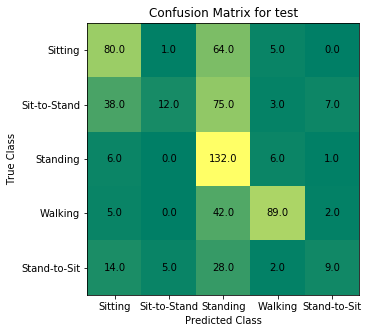

In [12]:
# Plot confusion matrix
fig = plt.figure(figsize=(5,5))
plt.tight_layout()
ax = fig.add_subplot(111)
res = ax.imshow(cmat, cmap=plt.cm.summer, interpolation='nearest')
width, height = cmat.shape
for x in xrange(width):
    for y in xrange(height):
        ax.annotate(str(cmat[x,y]), xy=(y, x),horizontalalignment='center',verticalalignment='center')
plt.xticks(range(width), classes, rotation=0)
plt.yticks(range(height), classes, rotation=0)
ax.set_xlabel('Predicted Class')
ax.set_ylabel('True Class')
plt.title('Confusion Matrix for test')
plt.show()

In [14]:
# save the prediction results in a text file
pred_file = os.path.join(checkpoint_dir, 'test_prediction.txt')
testing_labels_path = osp.join(TEST_LMDB, 'valid_data_list.txt')
labels_handler = open(testing_labels_path, "r")
lines = labels_handler.readlines()
with open(pred_file, 'wb') as f:
    f.write(" clip address, true class, predicted class \n")
    for j in range(len(pred)):
        indx = int(Ids[j]-1)
        f.write(lines[indx].rstrip()+'\t'+ classes[true[j]] + '\t'+ pred[j] + '\n')
        
labels_handler.close()
f.close()

IndexError: list index out of range